In [1]:
import os
import time
import random
import math
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from PIL import Image
from IPython.display import clear_output

import ai2thor
import ai2thor_colab
from ai2thor_colab import plot_frames
from ai2thor.controller import Controller

from ai2thor.platform import CloudRendering
controller = Controller(platform=CloudRendering)

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical

In [3]:
from network import DQN
from utils import to_torchdim, frame2tensor, plot_durations, encode_feedback

In [4]:
import warnings
warnings.filterwarnings('ignore')

plt.style.use('ggplot')

## Set Configs

In [5]:
is_cuda = torch.cuda.is_available()

if is_cuda: device = torch.device('cuda')
else: device = torch.device('cpu')

In [6]:
BUFFER_SIZE = int(3e4) # experience buffer/memory
BATCH_SIZE = 64
GAMMA = 0.999 # discounted return
EPS_START = 0.9
EPS_END = 0.05
NUM_EPISODES = 3000
TARGET_UPDATE = 4 # hard update

TAU = 1e-4 # for soft update of target parameters
LR = 2.5e-4

SCREEN_WIDTH = SCREEN_HEIGHT = 100

## Set Environment

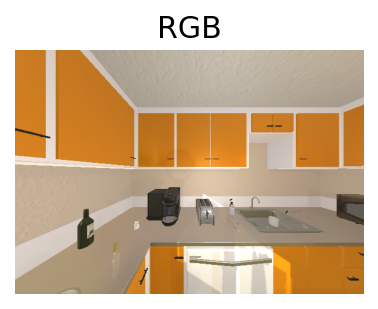

In [7]:
floor_index = random.randint(0, 30)
floor_index = 20

controller = Controller(
    agentMode = "default", # arm
    visibilityDistance = 1.5,
    scene = f"FloorPlan{floor_index}",

    # step sizes
    snapToGrid = True,
    gridSize = 0.25,
    rotateStepDegrees = 90,

    # image modalities
    renderInstanceSegmentation = False,
    renderDepthImage = False,
    renderSemanticSegmentation = False,
    renderNormalsImage = False,
    
    # camera properties
    width = 600,
    height = 420,
    fieldOfView = 120,
)

plot_frames(controller.last_event)

In [8]:
# action_space = ["MoveAhead", "MoveLeft", "MoveRight", "MoveBack", "RotateLeft", "RotateRight"]
action_space = ["MoveAhead", "MoveBack", "RotateLeft", "RotateRight"]

In [9]:
data = controller.last_event.metadata['objects']
object_space = [item['name'] for item in data]

## Set Replay Memory

In [10]:
class ReplayBuffer(object):
    """Fixed-size buffer to store experience tuples."""
    
    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayMemory object."""
        
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
        
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)
        self.batch_size = batch_size

    def add(self, state, action, reward, next_state, done):
        """Add a new experience to buffer."""
        
        self.memory.append(self.experience(state, action, reward, next_state, done))
        
    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)
        
        states = torch.from_numpy(np.vstack([exp.state for exp in experiences if exp is not None])).float()
        # print("--- states.size()")
        # print(states.size())
        states = states.to(device)
        
        actions = torch.from_numpy(np.vstack([exp.action for exp in experiences if exp is not None])).long()
        # print("--- actions.size()")
        # print(actions.size())
        actions = actions.to(device)
        
        rewards = torch.from_numpy(np.vstack([exp.reward for exp in experiences if exp is not None])).float()
        rewards = rewards.to(device)
        # print("--- rewards.size()")
        # print(rewards.size())
        
        next_states = torch.from_numpy(np.vstack([exp.next_state for exp in experiences if exp is not None])).float()
        next_states = next_states.to(device)
        # print("--- next_states.size()")
        # print(next_states.size())
        
        dones = torch.from_numpy(np.vstack([exp.done for exp in experiences if exp is not None]).astype(np.uint8)).float()
        dones = dones.to(device)
        # print("--- dones.size()")
        # print(dones.size())
        
        return (states, actions, rewards, next_states, dones)
        
    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

## Define Agent

In [11]:
class DQNAgent():
    """The agent interacting with and learning from the environment."""
    
    def __init__(self, screen_width, screen_height, action_size, seed):
        
        self.action_size = action_size
        self.seed = random.seed(seed)
        
        # Q-Network
        self.dqn_net = DQN(screen_width, screen_height, action_size, seed).to(device)
        self.target_net = DQN(screen_width, screen_height, action_size, seed).to(device)
        self.optimizer = optim.RMSprop(self.dqn_net.parameters(), lr=LR, alpha=0.95, eps=0.01)
        
        # Replay Buffer
        self.buffer = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, seed)
        self.time_step = 0
        
    def memorize(self, state, action, reward, next_state, done):
        """Save experience in replay buffer."""
        
        self.buffer.add(state, action, reward, next_state, done)
    
        self.time_step = (self.time_step + 1) % TARGET_UPDATE
        if self.time_step == 0:
            # if enough samples are available in memory, get random subset and learn
            if len(self.buffer) > BATCH_SIZE:
                experiences = self.buffer.sample()
                self.learn(experiences, GAMMA)
                
    def preprocess(self, state, screen_width, screen_height):
        
        resized_screen = Image.fromarray(state).resize((screen_width, screen_height))
        state = frame2tensor(to_torchdim(resized_screen)).to(torch.float32).to(device)

        return state
    
    def act(self, state, epsilon=0.):
        """Returns actions for given state as per current policy."""
        
        # epsilon-greedy action selection
        if random.random() > epsilon:
            self.dqn_net.eval()
            with torch.no_grad():
                action = self.dqn_net(state).max(1)[1].view(1, 1)
            self.dqn_net.train()
            
        else:
            action = torch.tensor([[random.randrange(len(action_space))]], dtype=torch.long, device=device)
            
        return action

    def learn(self, experiences, gamma):
        """Update value parameters using given batch of experience tuples."""
    
        states, actions, rewards, next_states, dones = experiences
        
        self.optimizer.zero_grad()
        
        # get index of maximum value for next state
        Qsa_next = self.dqn_net(next_states).detach()
        _, action_max = Qsa_next.max(1)

        # get max predicted Q values (for next states) from target network
        Q_target_next = self.target_net(next_states).detach().gather(1, action_max.unsqueeze(1))
        
        # compute Q target
        Q_target = rewards + (gamma * Q_target_next * (1 - dones))
        
        # get expected Q values from dqn network
        Q_expected = self.dqn_net(states).gather(1, actions)
        
        # compute loss
        loss = F.mse_loss(Q_expected, Q_target)
        
        # minimize the loss
        loss.backward()
        self.optimizer.step()
        
        # update target network
        self.soft_update(self.dqn_net, self.target_net, TAU)
        
    def soft_update(self, dqn_net, target_net, tau):
        """Soft update target network parameters."""
        
        for dqn_param, target_param in zip(dqn_net.parameters(), target_net.parameters()):
            target_param.data.copy_(tau*dqn_param.data + (1.0-tau) * target_param.data)

In [12]:
agent = DQNAgent(screen_width=SCREEN_WIDTH, screen_height=SCREEN_HEIGHT, action_size=len(action_space), seed=90)

## Train DQN

In [13]:
steps_done = 0

# define linear decay
def calculate_epsilon(episode):
    slope = (EPS_END - EPS_START) / NUM_EPISODES
    epsilon = EPS_START + slope * episode

    return max(epsilon, EPS_END)

In [16]:
def train_network(num_episodes, max_time):
    
    epsilon = EPS_START

    for i_episode in range(1, num_episodes+1):
        
        # initialize the environment and state
        controller.reset(random=True)
        
        state = agent.preprocess(controller.last_event.frame, 
                                 screen_width=SCREEN_WIDTH, screen_height=SCREEN_HEIGHT)
                                  
        total_score = 0
        
        for time_step in range(1, max_time+1):
            
            # select and perform an action using dqn network
            action = agent.act(state, epsilon)
            event = controller.step(action = action_space[action.item()])
            
            _, reward, done, _ = encode_feedback(event, controller, target_name="LightSwitch_bf8119ce")
            total_score += reward
            reward = torch.tensor([reward], device=device)

            if not done:
                next_state = agent.preprocess(controller.last_event.frame, 
                                              screen_width=SCREEN_WIDTH, screen_height=SCREEN_HEIGHT)
            else:
                next_state = None

            # store the transition in memory
            print("--- state.shape:", state.shape)
            print("--- action.shape:", action.shape)
            print("--- reward.shape:", reward.shape)
            print("--- next_state.shape:", next_state.shape)
            agent.memorize(state, action, reward, next_state, done)

            # move to the next state
            state = next_state

            if done or time_step==max_time:
                plot_durations(total_score, i_episode, num_episodes)
                break

        epsilon = calculate_epsilon(i_episode)

    if not os.path.exists('./agents/'): os.makedirs('./agents/')
    torch.save(dqn_net.state_dict(), f'./agents/AI2THOR_RL.pth')
    print('Training completed.')
    plt.ioff()
    plt.show()

In [17]:
print('Training the network...')
train_network(num_episodes=NUM_EPISODES, max_time=400)

--- state.shape: torch.Size([1, 3, 100, 100])
--- action.shape: torch.Size([1, 1])
--- reward.shape: torch.Size([1])
--- next_state.shape: torch.Size([1, 3, 100, 100])
--- state.shape: torch.Size([1, 3, 100, 100])
--- action.shape: torch.Size([1, 1])
--- reward.shape: torch.Size([1])
--- next_state.shape: torch.Size([1, 3, 100, 100])
--- state.shape: torch.Size([1, 3, 100, 100])
--- action.shape: torch.Size([1, 1])
--- reward.shape: torch.Size([1])
--- next_state.shape: torch.Size([1, 3, 100, 100])
--- state.shape: torch.Size([1, 3, 100, 100])
--- action.shape: torch.Size([1, 1])
--- reward.shape: torch.Size([1])
--- next_state.shape: torch.Size([1, 3, 100, 100])
--- state.shape: torch.Size([1, 3, 100, 100])
--- action.shape: torch.Size([1, 1])
--- reward.shape: torch.Size([1])
--- next_state.shape: torch.Size([1, 3, 100, 100])
--- state.shape: torch.Size([1, 3, 100, 100])
--- action.shape: torch.Size([1, 1])
--- reward.shape: torch.Size([1])
--- next_state.shape: torch.Size([1, 3, 100

--- state.shape: torch.Size([1, 3, 100, 100])
--- action.shape: torch.Size([1, 1])
--- reward.shape: torch.Size([1])
--- next_state.shape: torch.Size([1, 3, 100, 100])
--- state.shape: torch.Size([1, 3, 100, 100])
--- action.shape: torch.Size([1, 1])
--- reward.shape: torch.Size([1])
--- next_state.shape: torch.Size([1, 3, 100, 100])
--- state.shape: torch.Size([1, 3, 100, 100])
--- action.shape: torch.Size([1, 1])
--- reward.shape: torch.Size([1])
--- next_state.shape: torch.Size([1, 3, 100, 100])
--- state.shape: torch.Size([1, 3, 100, 100])
--- action.shape: torch.Size([1, 1])
--- reward.shape: torch.Size([1])
--- next_state.shape: torch.Size([1, 3, 100, 100])
--- state.shape: torch.Size([1, 3, 100, 100])
--- action.shape: torch.Size([1, 1])
--- reward.shape: torch.Size([1])
--- next_state.shape: torch.Size([1, 3, 100, 100])
--- state.shape: torch.Size([1, 3, 100, 100])
--- action.shape: torch.Size([1, 1])
--- reward.shape: torch.Size([1])
--- next_state.shape: torch.Size([1, 3, 100

--- state.shape: torch.Size([1, 3, 100, 100])
--- action.shape: torch.Size([1, 1])
--- reward.shape: torch.Size([1])
--- next_state.shape: torch.Size([1, 3, 100, 100])
--- state.shape: torch.Size([1, 3, 100, 100])
--- action.shape: torch.Size([1, 1])
--- reward.shape: torch.Size([1])
--- next_state.shape: torch.Size([1, 3, 100, 100])
--- state.shape: torch.Size([1, 3, 100, 100])
--- action.shape: torch.Size([1, 1])
--- reward.shape: torch.Size([1])
--- next_state.shape: torch.Size([1, 3, 100, 100])
--- state.shape: torch.Size([1, 3, 100, 100])
--- action.shape: torch.Size([1, 1])
--- reward.shape: torch.Size([1])
--- next_state.shape: torch.Size([1, 3, 100, 100])
--- state.shape: torch.Size([1, 3, 100, 100])
--- action.shape: torch.Size([1, 1])
--- reward.shape: torch.Size([1])
--- next_state.shape: torch.Size([1, 3, 100, 100])
--- state.shape: torch.Size([1, 3, 100, 100])
--- action.shape: torch.Size([1, 1])
--- reward.shape: torch.Size([1])
--- next_state.shape: torch.Size([1, 3, 100

AttributeError: 'NoneType' object has no attribute 'shape'

## Check The Result!

In [ ]:
# load the weights of smart agent
dqn_net.load_state_dict(torch.load(f'./agents/AI2THOR_RL.pth'));

In [ ]:
num_episodes = 20
best_score = -np.inf

for i_episode in range(1, num_episodes+1):
    
    # initialize the environment and state
    controller.reset(random=True)

    screen = controller.last_event.frame
    resized_screen = Image.fromarray(screen).resize((screen_width, screen_height))

    state = frame2tensor(to_torchdim(resized_screen)).to(torch.float32).to(device)
    
    total_score = 0
    
    for time_step in range(1, 100):
        
        # select an action using the trained dqn network
        with torch.no_grad():
            print(dqn_net(state))
            action = dqn_net(state).max(1)[1].view(1, 1)
        
        # clear_output(wait=True)
        
        print("Episode:", i_episode+1)
        print("Action:", time_step+1)
        if action_space[action.item()] == "RotateLeft" or action_space[action.item()] == "RotateRight":
            print("Action:\033[91m", action_space[action.item()])
        else:
            print("Action:\033[92m", action_space[action.item()])

        event = controller.step(action = action_space[action.item()])
        
        time.sleep(1)
            
        _, reward, done, _ = encode_feedback(event, controller, target_name="LightSwitch_887b121a")
            
        # observe a new state
        if not done:
            screen = controller.last_event.frame
            resized_screen = Image.fromarray(screen).resize((screen_width, screen_height))

            next_state = frame2tensor(to_torchdim(resized_screen)).to(torch.float32).to(device)
        else:
            next_state = None
                
        state = next_state
        total_score += reward
        if done:
            break
            
    if total_score > best_score: 
        best_score = total_score
        
    print(f'\rEpisode {i_episode}/{num_episodes}, Best Score: {best_score}', end='')  

In [ ]:
controller.stop()

In [ ]:
# Todo list
# 1. Modify DQN to align with AI2THOR not Gym ✅
# 2. Modify train_network to align with AI2THOR not Gym ✅
# 3. Design reward ✅
# 4. Change epsilon strategy ✅
# 5. Apply Random initialization

In [ ]:
# CHECK!
# 1. Epsilon greedy strategy ✅
# 2. Make sure update target network ✅

---